### Criando um suporte de atendimento com Langchain que deve ter um contexto do funcionamento de um produto da empresa e que ao atender um usuario deve pode consultar o manual do produto para sugerir alternativa para resolver o problema antes de encaminhar para um atendimento pessoal com um atendente.
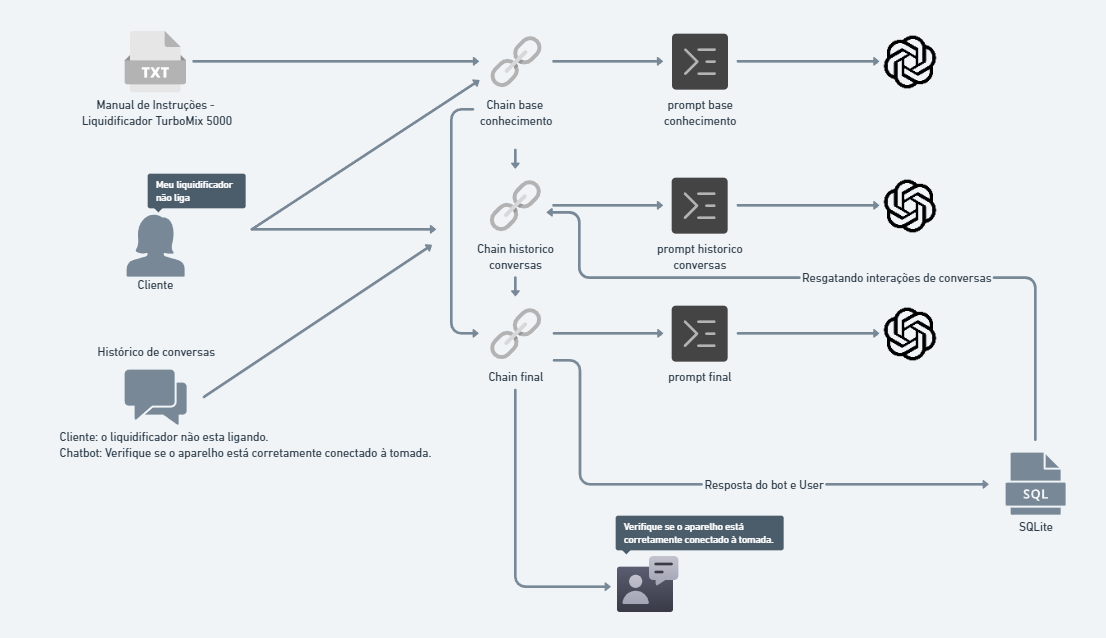

In [2]:
!pip install langchain
!pip install langchain-openai
!pip install python-dotenv
!pip install langchain-community

In [649]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain_community.chat_message_histories import SQLChatMessageHistory

In [650]:
OPENAI_API_KEY = ""
openai = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=OPENAI_API_KEY, temperature=0)


- Criando o banco e a conexão

In [651]:
chat_message_history = SQLChatMessageHistory(
    session_id="test_session_id", connection_string="sqlite:///sqlite.db"
)

# SequentialChain

In [668]:
# Carregando os documentos
loader = TextLoader("Manual de Instruções - Liquidificador TurboMix 5000.txt")
documents = loader.load()

In [669]:
print(documents[0])

page_content='﻿Manual de Instruções - Liquidificador TurboMix 5000
Bem-vindo ao Liquidificador TurboMix 5000!
Parabéns por adquirir o Liquidificador TurboMix 5000! Este guia foi desenvolvido para ajudar você a utilizar seu liquidificador com segurança, otimizando seu desempenho. Leia com atenção para aproveitar ao máximo as funcionalidades do seu novo aparelho.
________________


1. Montagem do Liquidificador
Siga os passos abaixo para montar seu liquidificador corretamente:
1. Base e Copo:
   * Coloque a base do liquidificador sobre uma superfície plana e estável.
   * Posicione o copo do liquidificador sobre a base, alinhando-o corretamente. Certifique-se de que ele esteja bem encaixado.
2. Lâmina:
   * Insira a lâmina no fundo do copo. Ela deve se encaixar firmemente.
   * Verifique se a lâmina está bem presa e sem folgas.
3. Tampa:
   * Coloque a tampa sobre o copo, ajustando para que esteja completamente vedada.
   * Encaixe o medidor (pequeno copo central) no orifício da tampa, s

In [684]:
# carregando historico de conversas
historico_conversas = "".join([f"{msg.__class__.__name__}:{msg.content}" for msg in chat_message_history.messages])

In [685]:
# Pergunta do cliente 
pergunta = input("Olá ao assitente tecnico digital da TurboMix 5000 \nComo posso ajudalo : ")


- Entrada dos valores que serão setados nos templates e nos chains para executar as respostas com o modelo

In [686]:
inputs = {
    "context": "\n".join(doc.page_content for doc in documents),
    "question": "",
    "historico": historico_conversas
}

### Criando os prompts de entra que vão ter o template com as instruções de cada elo da interação para fornecer uma resposta com base no contexto das instruções da empresa e um histórico de conversa entre o chat e o usuário.

In [688]:
prompt_base_conhecimento = PromptTemplate(
    input_variables=['context', 'question'],
    template="""
        Use o seguinte contexto para responder à pergunta.
        Responda apenas com base nas informações fornecidas.
        Não forneça instruções de procedimentos já realizados.
        Passe uma instrução do topico encontrado.
        Carrege as infomações do "Contato para Suporte" 
        caso o problema nao seja solucionado as informações serão enviadas na messagem.
        Não utilize informações externas ao contexto:
        contexto: {context}
        pergunta: {question}
    """
)

In [689]:
prompt_historico_conversa = PromptTemplate(
    input_variables=['historico', 'question'],
    template="""
        Use o histórico de convesas para responder à pergunta.
        Responda apenas com base nas informações fornecidas.
        Não forneça instruções de procedimento já realizados.
        Não utilize informações externas ao contexto:
        Histórico: {historico}
        Pergunta: {question}
    """
)

In [690]:
print(prompt_historico_conversa)

input_variables=['historico', 'question'] template='\n        Use o histórico de convesas para responder à pergunta.\n        Responda apenas com base nas informações fornecidas.\n        Não forneça instruções de procedimento já realizados.\n        Não utilize informações externas ao contexto:\n        Histórico: {historico}\n        Pergunta: {question}\n    '


In [691]:
prompt_final = PromptTemplate(
    input_variables=['resposta_base_conhecimento', 'resposta_historico_conversas'],
    template="""
        Combine as seguintes respostas para gerar uma resposta final.
        Não passe todas as informações de uma vez na mesma messagem.
        Passe as instruções uma por vez para auxiliar o antedimento.
        E aguarde um retorno caso não tenha resolvido passe a proxima.
        Mas não forneça instruções de procedimentos já realizados.
        Caso não aja mais instruções para solucionar passe as informações do "Contato para Suporte":
        Resposta da base de conhecimento: {resposta_base_conhecimento}
        Resposta do histórico de conversas: {resposta_historico_conversas}
    """
)

In [692]:
print(prompt_base_conhecimento)

input_variables=['context', 'question'] template='\n        Use o seguinte contexto para responder à pergunta.\n        Responda apenas com base nas informações fornecidas.\n        Não forneça instruções de procedimentos já realizados.\n        Passe uma instrução do topico encontrado.\n        Carrege as infomações do "Contato para Suporte" \n        caso o problema nao seja solucionado as informações serão enviadas na messagem.\n        Não utilize informações externas ao contexto:\n        contexto: {context}\n        pergunta: {question}\n    '


In [693]:
# Definir as cadeias 
chain_base_conhecimento = prompt_base_conhecimento | openai
chain_historico_conversas = prompt_historico_conversa | openai
chain_final = prompt_final | openai

In [694]:
print(chain_base_conhecimento)

first=PromptTemplate(input_variables=['context', 'question'], template='\n        Use o seguinte contexto para responder à pergunta.\n        Responda apenas com base nas informações fornecidas.\n        Não forneça instruções de procedimentos já realizados.\n        Passe uma instrução do topico encontrado.\n        Carrege as infomações do "Contato para Suporte" \n        caso o problema nao seja solucionado as informações serão enviadas na messagem.\n        Não utilize informações externas ao contexto:\n        contexto: {context}\n        pergunta: {question}\n    ') last=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000001B1A2E81FD0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000001B1A2E8D0D0>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')


In [695]:
print(resultado_historico_conversas)

content='Resposta: Se mesmo após ter verificado todas as instruções fornecidas o liquidificador ainda não está ligando, recomendo que entre em contato com o suporte através do telefone 0800-123-4567 ou pelo e-mail suporte@turbomix5000.com para obter assistência adicional.' response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 255, 'total_tokens': 324, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-cae6b138-09d9-40f4-8870-0946478e9e8d-0' usage_metadata={'input_tokens': 255, 'output_tokens': 69, 'total_tokens': 324}


In [696]:
# Passando dados e executando
resultado_base_conhecimento = chain_base_conhecimento.invoke({"context":inputs["context"], "question": inputs["question"]})
resultado_historico_conversas = chain_historico_conversas.invoke({"historico": inputs["historico"], "question": inputs["question"]})
resultado_final = chain_final.invoke({"resposta_base_conhecimento": resultado_base_conhecimento,
                                      "resposta_historico_conversas": resultado_historico_conversas})

- Salvando conversa no banco

In [697]:
chat_message_history.add_user_message(inputs["question"])
chat_message_history.add_ai_message(resultado_final.content)

In [702]:
#visualizando todas messagens
chat_message_history.messages

[HumanMessage(content='Meu liquidificador não esta ligando'),
 AIMessage(content='Para resolver o problema do liquidificador que não está ligando, verifique se o cabo de energia está corretamente conectado à tomada e se o botão de ligar está funcionando corretamente. Além disso, verifique se o liquidificador não está superaquecido e se não há nenhum objeto obstruindo as lâminas.\n\nCaso o problema persista, verifique se o aparelho está corretamente conectado à tomada e se o copo e a base estão bem encaixados.\n\nSe mesmo assim o problema persistir, entre em contato com o suporte através do telefone 0800-123-4567 ou pelo e-mail suporte@turbomix5000.com.'),
 HumanMessage(content='permanece sem ligar mesmo tendo realizado as instruções '),
 AIMessage(content='Verifique se o liquidificador está corretamente conectado à tomada e se o botão de ligar está pressionado.\n\nCaso o liquidificador ainda não esteja ligando, verifique se o cabo de energia está danificado ou se há algum problema na t